In [1]:
#Import Turing, Distributions, LinearAlgebra and DataFrames
using Turing, Distributions, StatsBase, DataFrames, CSV

# Import MCMCChain, Plots, StatsPlots, GraphPlot, GraphRecipes, PyCall and Statistics for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/RZOZ8/src/Turing.jl:24


false

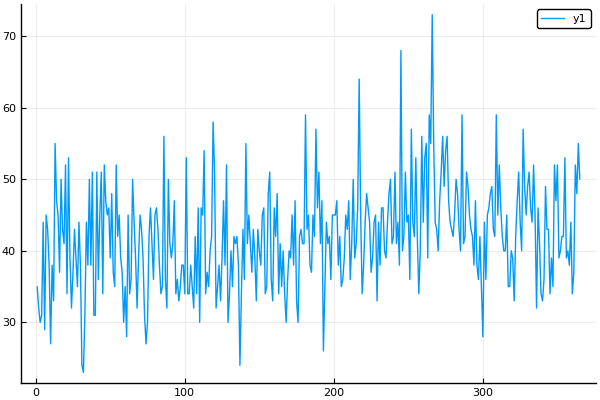

In [2]:
df = CSV.read("daily-total-female-births.csv")
s = Int64[]
for ele in df[:Births]
    push!(s, ele)
end
pyplot()
plot(s)

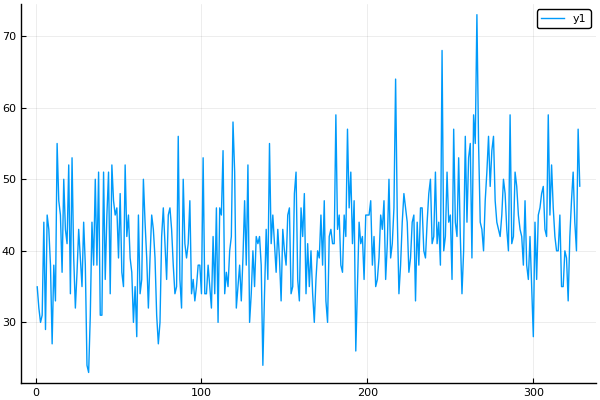

In [3]:
train_percentage = 0.9
s_train = s[1:floor(Int, train_percentage*length(s))]
N = length(s_train)
pyplot()
plot(s_train)

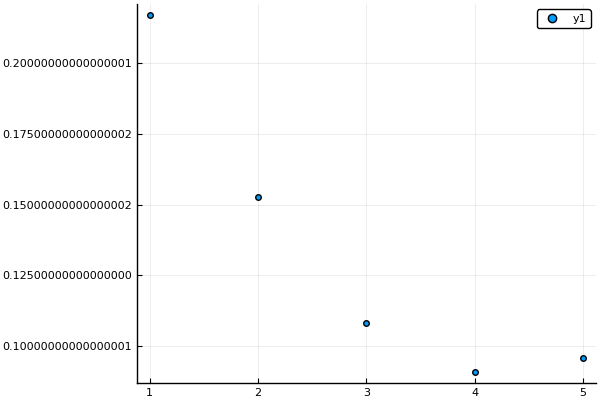

In [4]:
scatter([1, 2, 3, 4, 5], autocor(s, [1, 2, 3, 4, 5]))

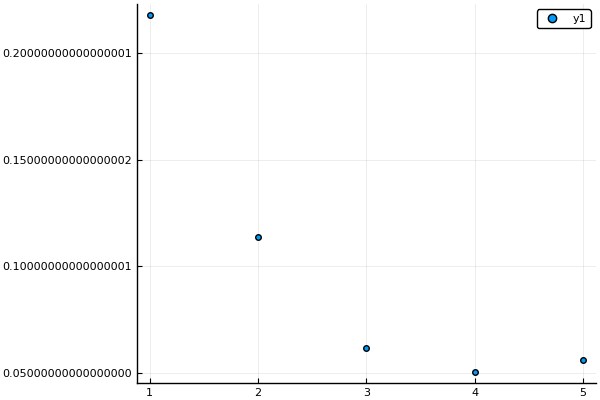

In [5]:
scatter([1, 2, 3, 4, 5], pacf(s, [1, 2, 3, 4, 5]))

In [6]:
σ = 1
@model AR(x, N) = begin
    α ~ Normal(0,σ) 
    beta_1 ~ Uniform(-1, 1)
    beta_2 ~ Uniform(-1, 1)
    for t in 3:N
        μ = α + beta_1 * x[t-1] + beta_2 * x[t - 2] 
        x[t] ~ Normal(μ, 0.1) 
    end
end;

In [7]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sample using HMC
chain = sample(AR(s_train, N), NUTS(500, 200, 0.65) )

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/support/hmc_core.jl:247
┌ Info: [Turing] found initial ϵ: 0.0006180677679367365
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/support/hmc_core.jl:239
┌ Info:  Adapted ϵ = 0.0003666923872828032, std = [1.0, 1.0, 1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/adapt/adapt.jl:90


[NUTS] Finished with
  Running time        = 8.294533953000009;
  #lf / sample        = 0.0;
  #evals / sample     = 0.002;
  pre-cond. metric    = [1.0, 1.0, 1.0].


Object of type Chains, with data of type 500×9×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = beta_1, α, beta_2

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std       │ naive_se   │ mcse      │ ess     │
│     │ Symbol     │ Float64 │ Float64   │ Float64    │ Float64   │ Any     │
├─────┼────────────┼─────────┼───────────┼────────────┼───────────┼─────────┤
│ 1   │ beta_1     │ 0.46682 │ 0.101291  │ 0.00452988 │ 0.0397186 │ 2.95145 │
│ 2   │ beta_2     │ 0.37218 │ 0.0857125 │ 0.00383318 │ 0.0249545 │ 4.42587 │
│ 3   │ α          │ 6.41967 │ 5.14595   │ 0.230134   │ 2.48208   │ 2.03584 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64 

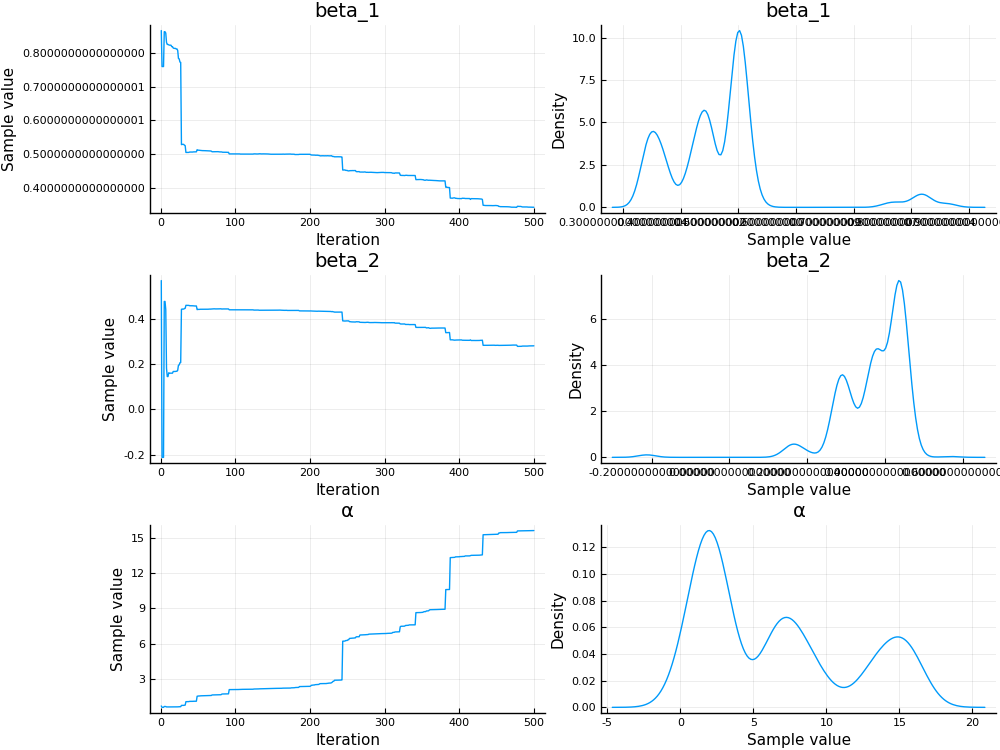

In [8]:
plot(chain)

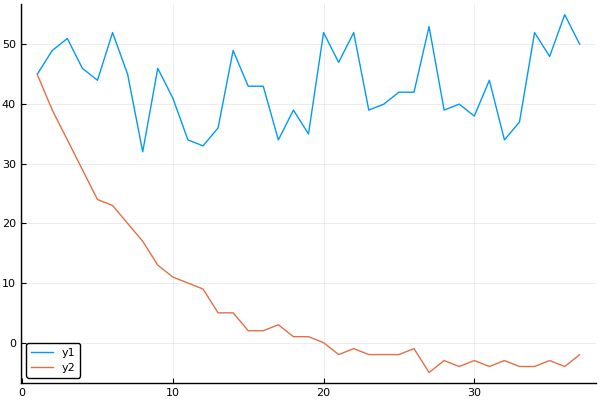

In [9]:
chains_new = chain[50:500]
beta_1 = mean(chains_new[:beta_1].value)
beta_2 = mean(chains_new[:beta_2].value)
s_test = s[N + 1:length(s)]
s_pred = Int64[]
first_ele = floor(Int, s_train[N]*beta_1 + s_train[N - 1]*beta_2 + rand(Normal(0,1)))
push!(s_pred, first_ele)
second_ele = floor(Int, s_pred[1]*beta_1 + s_train[N]*beta_2 + rand(Normal(0,1)))
push!(s_pred, second_ele)
for i=3:length(s_test)
    next_ele = floor(Int, s_pred[i - 1]*beta_1 + s_pred[i - 2]*beta_2 + rand(Normal(0,1)))
    push!(s_pred, next_ele)
end
plot(s_test)
plot!(s_pred)

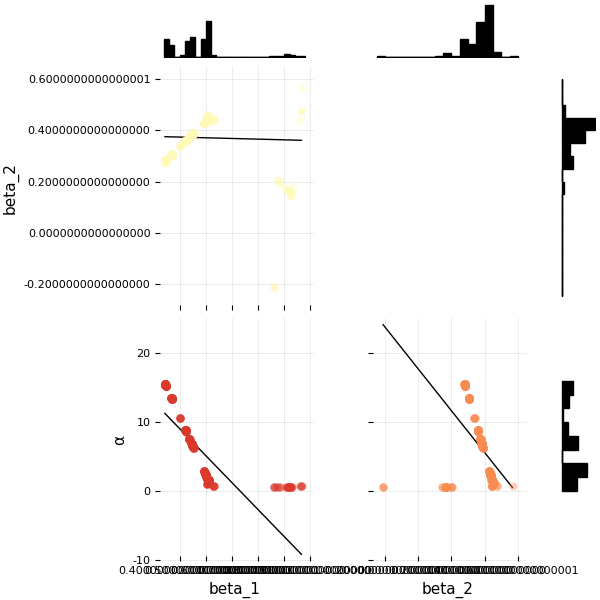

In [10]:
corner(chain)